In [26]:
import os,sys
import torch
import torchvision
import argparse
import tqdm
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from datasets import *
from utils import *
from torchvision.models.feature_extraction import create_feature_extractor

In [27]:
import matplotlib.pyplot as plt
import cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [29]:
# dpath = '/ailab_mat/dataset/ISIC_skin_disease'
# dpath = '/ailab_mat/dataset/ILSVRC/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def gen_cam(feat, weight):
    pass

In [6]:
testset = ISIC2017(dpath, 'Test', None)
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)

model = models.resnet18()
model.fc = nn.Linear(512, 30)

return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)

model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/ilsvrc/seed0/baseline/ACC_65.93.pth'))

criterion = nn.CrossEntropyLoss()

In [7]:
model.eval()
i = 0
for inputs, labels, masks in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    if pred != labels:
        img = F2.to_pil_image(inputs[0])
        mask = F2.to_pil_image(masks[0])
        img.save(f'./pictures/image{i}.jpg')
        mask.save(f'./pictures/mask{i}.jpg')
        i += 1

In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F2.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(0.0, 133.18775431650033, 105.12156524719315)
torch.Size([3, 224, 224])
tensor([[ 67.,  76., 141., 190.]])


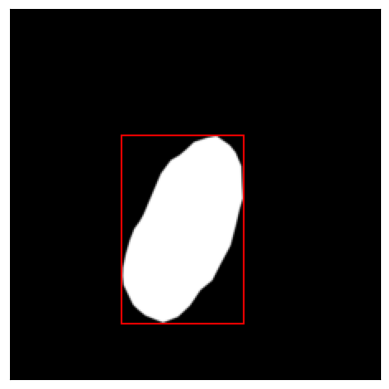

In [14]:
inputs, _, mask = testset[1]
np_mask = mask.numpy()

from scipy import ndimage
com = ndimage.center_of_mass(np_mask)
print(com)

masked_input = inputs * mask
print(masked_input.shape)

from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(mask)
print(boxes)
from torchvision.utils import draw_bounding_boxes

boxes = boxes.type(torch.uint8)
mask = (mask*255).type(torch.uint8)
mask_with_box = draw_bounding_boxes(mask, boxes, colors="red")
# mask_with_box = (mask_with_box*255).type(torch.uint8)
show(mask_with_box)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 114, 74])


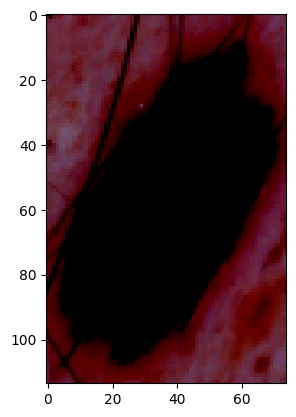

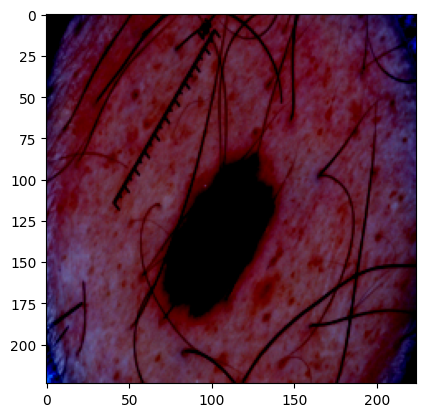

In [25]:
croped_img = F2.crop(inputs, boxes[0][1],boxes[0][0],boxes[0][3]-boxes[0][1],boxes[0][2]-boxes[0][0])
print(croped_img.shape)

plt.figure()
plt.imshow(croped_img.permute(1,2,0))

background = torch.zeros_like(inputs)
background[:,boxes[0][1]:boxes[0][3],boxes[0][0]:boxes[0][2]] = croped_img
# print(background[:,boxes[0][0]:boxes[0][2],boxes[0][1]:boxes[0][3]].shape)
plt.figure()
plt.imshow(inputs.permute(1,2,0))
# plt.imshow(background.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


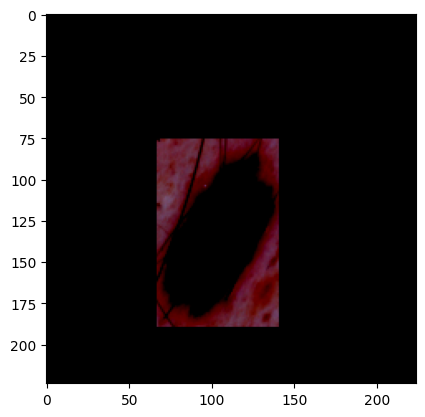

In [26]:
plt.figure()
plt.imshow(background.permute(1,2,0))

In [100]:
model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/isic/seed0/baseline/ACC_79.33.pth'
# model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/isic/seed0/Mask_ALL2_2/ACC_81.33.pth'
d_path = '/ailab_mat/dataset/ISIC_skin_disease/sample/sample4.jpg'


model = models.resnet18()
model.fc = nn.Linear(512, 3)
return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)
model.load_state_dict(torch.load(model_path))

image = Image.open(d_path)
print(image.size)
width, height = image.size
IMG = image

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
            [transforms.Resize((224,224)),
            transforms.RandomInvert(p=1.0),
            transforms.ToTensor(),
            normalize,
            ])
image = transform(image)
if image.shape[0] != 1:
    image = image.unsqueeze(0)
image = image.to(device)
print(image.shape)
outputs = model(image)
f4 = outputs['l4']
_, pred = torch.max(outputs['fc'], 1)
print(f4.shape)
print(pred.item())

(600, 450)
torch.Size([1, 3, 224, 224])
torch.Size([1, 512, 7, 7])
0


In [38]:
print(list(model.parameters())[-2].shape)

torch.Size([3, 512])


torch.Size([450, 600])


(-0.5, 599.5, 449.5, -0.5)

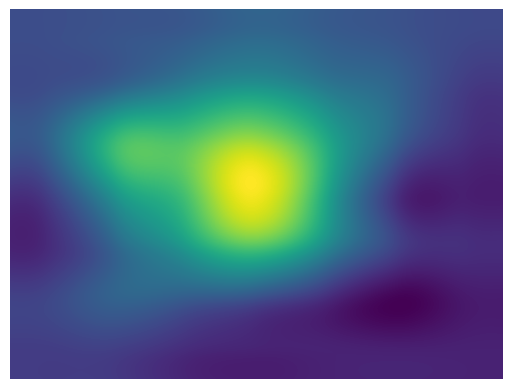

In [101]:
feat = torch.reshape(f4, [-1,512,7*7])
weights = list(model.parameters())[-2]
weight = weights[int(pred.item())]
weight = weight.unsqueeze(0).unsqueeze(0)

cam = torch.bmm(weight, feat)
cam = torch.reshape(cam, (1,7,7))
cam = cam-torch.min(cam)
cam = cam/torch.max(cam)
# cam = torch.sigmoid(cam)
cam = cam.unsqueeze(1)
cam = F.interpolate(cam, size=(height, width), mode='bicubic')
cam = cam.squeeze()

print(cam.shape)
plt.figure()
plt.imshow(cam.detach().cpu())
plt.axis(False)

(-0.5, 599.5, 449.5, -0.5)

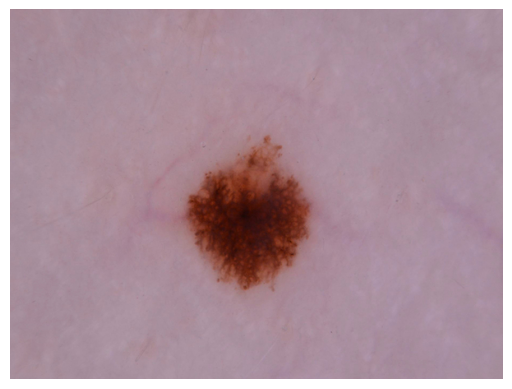

In [99]:
plt.figure()
plt.imshow(IMG)
plt.axis(False)

In [39]:
import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

model = models.resnet18()
train_nodes, eval_nodes = get_graph_node_names(models.resnet18())
print(train_nodes)
return_nodes = {
    'layer1':'layer1',
    'layer2':'layer2',
    'layer3':'layer3',
    'layer4':'layer4',
    'fc':'fc'
}
body = create_feature_extractor(model, return_nodes=return_nodes)

import torch
x = torch.randn([2,3,224,224])
out = body(x)
print(type(out))
# print(out['fc'].shape)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

(1080, 1920, 3)
(1080, 1920)


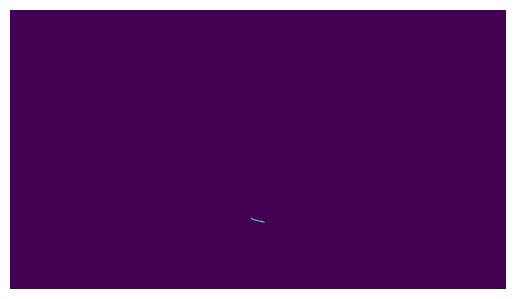

In [51]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import torchvision.transforms.functional as F2

img = Image.open('/ailab_mat/dataset/auto_mobile_korea/daytime/data/Training/source/08_104504_220613_05.jpg')
img = np.array(img)
print(img.shape)

image_shape = (1080, 1920)
polygon = [
                986,
                823,
                982,
                818,
                958,
                813,
                937,
                807,
                936,
                804,
                935,
                804,
                932,
                806,
                934,
                809,
                952,
                815
            ]
polygon = np.array([[polygon[i+1],polygon[i]] for i in range(0,len(polygon),2)])
# print(polygon)
mask = skimage.draw.polygon2mask(image_shape, polygon)
plt.figure()
plt.imshow(mask)
# mask = np.stack([mask, mask, mask], axis=2)
# plt.imshow(mask*img)
# plt.gca().invert_xaxis()
plt.axis(False)
print(mask.shape)

In [3]:
import json

with open('/ailab_mat/dataset/bdd100k/bdd100k_labels_images_train.json', 'r') as f:
    train_annot = json.load(f)
    
for anno in train_annot:
    if anno['name'] == '5e852617-49aecd0b.jpg':
        print(anno['labels'])

[{'category': 'person', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 12.044518, 'y1': 226.462338, 'x2': 82.919468, 'y2': 337.837263}, 'id': 1030879}, {'category': 'person', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 838.918949, 'y1': 243.337328, 'x2': 874.356424, 'y2': 326.024771}, 'id': 1030880}, {'category': 'person', 'attributes': {'occluded': True, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 59.294485, 'y1': 226.462338, 'x2': 101.481955, 'y2': 329.399767}, 'id': 1030881}, {'category': 'person', 'attributes': {'occluded': True, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 692.10655, 'y1': 243.337328, 'x2': 725.856527, 'y2': 324.337273}, 'id': 103

In [23]:
import os, sys
from glob import glob

filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Training/source/*.jpg')
train_list = []
for name in filelist:
    if 'left' in name or 'right' in name:
        continue
    else:
        train_list.append(name.split('/')[-1].split('.')[0])
        
filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Validation/source/*.jpg')
val_list = []
for name in filelist:
    if 'left' in name or 'right' in name:
        continue
    else:
        val_list.append(name.split('/')[-1].split('.')[0])

train_list.sort()
val_list.sort()

print(len(train_list))
print(len(val_list))
print(train_list[:5])
print(val_list[:5])

4440
4440
['08_102940_220615_01', '08_102940_220615_02', '08_102940_220615_03', '08_102940_220615_04', '08_102940_220615_05']
['08_085504_221103_01', '08_085504_221103_02', '08_085504_221103_03', '08_085504_221103_04', '08_085504_221103_05']


In [25]:
from glob import glob

filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Training/label/*.json')
# filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Validation/label/*.json')

only_label = [name.split('/')[-1].split('.')[0] for name in filelist if name.split('/')[-1].split('.')[0] not in val_list]
print(only_label)
print(len(only_label))

['22_132739_221019_07', '22_132739_221019_05', '22_132739_221019_26', '22_132739_221019_11', '22_132739_221019_18', '22_132739_221019_06', '22_132739_221019_03', '22_132739_221019_15', '22_132739_221019_04', '22_132739_221019_14', '22_132739_221019_02', '22_132739_221019_39', '22_132739_221019_33', '22_132739_221019_13', '22_132739_221019_20', '22_132739_221019_09', '22_132739_221019_27', '22_132739_221019_17', '22_132739_221019_10', '22_132739_221019_01', '22_132739_221019_29', '22_132739_221019_16', '22_132739_221019_12', '22_132739_221019_08', '22_132739_221019_23', '22_132739_221019_19', '22_132739_221019_21', '22_132739_221019_22', '22_132739_221019_24', '22_132739_221019_28', '22_132739_221019_38', '22_132739_221019_40', '22_132739_221019_25', '22_132739_221019_36', '22_132739_221019_35', '22_132739_221019_30', '22_132739_221019_31', '22_132739_221019_32', '22_132739_221019_34', '22_132739_221019_37', '22_132759_221019_06', '22_132759_221019_03', '22_132759_221019_04', '22_132759